# Imports and loading data

In [33]:
import torch
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
diabete = load_diabetes(return_X_y=False,as_frame=True,scaled=True).frame

## Data preprocessing



In [34]:
# Check the correlation between features and target
corr_matrix = diabete.corr()
corr_matrix['target'].sort_values(ascending=False)

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

In [35]:
# I delete some unrelated columns. sex, s2, age, s1 are somehow unrelated
diabete.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

In [36]:
diabete.drop(['age','sex', 's1','s2'], inplace=True, axis=1)
diabete

,bmi,bp,s3,s4,s5,s6,target
0,0.061696,0.021872,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.051474,-0.026328,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.044451,-0.005670,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.011595,-0.036656,-0.036038,0.034309,0.022688,-0.009362,206.0
4,-0.036385,0.021872,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...
437,0.019662,0.059744,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.015906,-0.067642,-0.028674,0.034309,-0.018114,0.044485,104.0
439,-0.015906,0.017293,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,0.039062,0.001215,-0.028674,0.026560,0.044529,-0.025930,220.0


In [37]:
X = diabete.drop(['target'],axis=1).to_numpy()
y = diabete['target'].to_numpy()

array([[<Axes: title={'center': 'bmi'}>, <Axes: title={'center': 'bp'}>,
        <Axes: title={'center': 's3'}>],
       [<Axes: title={'center': 's4'}>, <Axes: title={'center': 's5'}>,
        <Axes: title={'center': 's6'}>],
       [<Axes: title={'center': 'target'}>, <Axes: >, <Axes: >]],
      dtype=object)

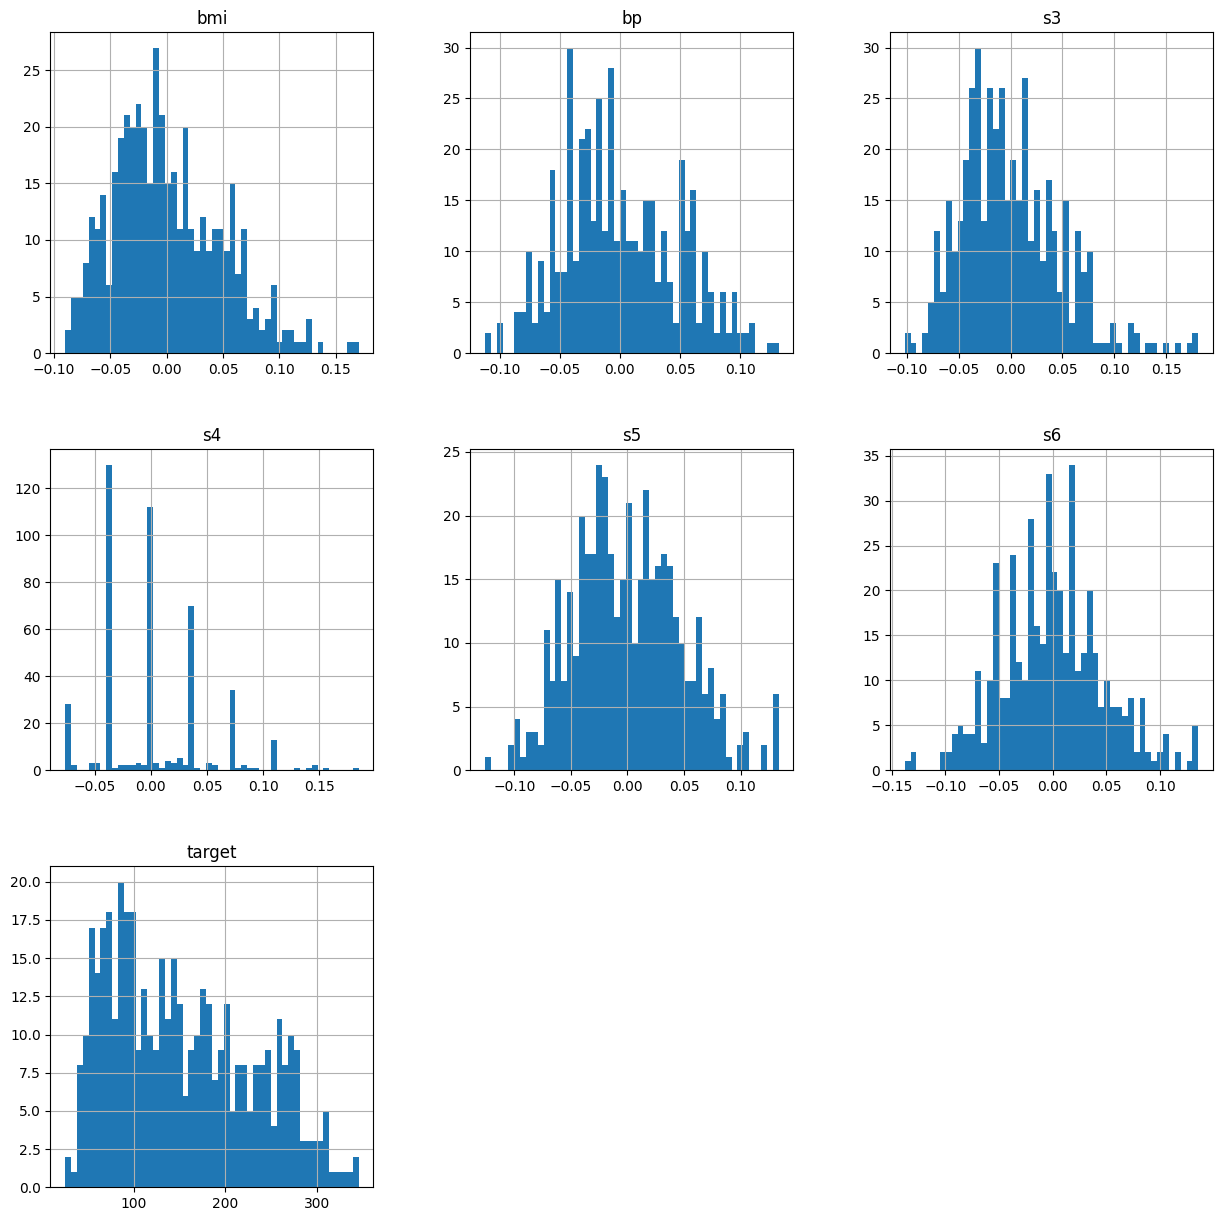

In [38]:
diabete.hist(bins=50, figsize=(15,15))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)




X_train_tensor[:,0].size(),y_train_tensor.size()

(torch.Size([353]), torch.Size([353, 1]))

# Training the model

In [40]:
from torch import nn

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(6,128),
        nn.ReLU(),
        nn.Linear(128,1)
        )
    
        
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.net(x)

## Raw model

In [41]:
torch.manual_seed(42)

linear_model = LinearRegressionModel()

linear_model.state_dict()

OrderedDict([('net.0.weight',
              tensor([[ 0.3121,  0.3388, -0.0956,  0.3750, -0.0894,  0.0824],
                      [-0.1988,  0.2398,  0.3599, -0.2995,  0.3548,  0.0764],
                      [ 0.3016,  0.0553,  0.1969, -0.0576,  0.3147,  0.0603],
                      [-0.1906,  0.1041, -0.1881, -0.0479, -0.1658,  0.2708],
                      [-0.3223, -0.1882, -0.1153, -0.2455,  0.0385, -0.4032],
                      [ 0.3687, -0.3468,  0.3152,  0.0679, -0.1326,  0.2523],
                      [ 0.0636,  0.3298,  0.0446, -0.1288,  0.1097, -0.1107],
                      [ 0.1718,  0.3645,  0.2360, -0.1785,  0.2357,  0.0730],
                      [ 0.2073, -0.2488, -0.4041, -0.1577, -0.3131,  0.3350],
                      [ 0.1176,  0.1691,  0.1291, -0.0071,  0.3195, -0.2901],
                      [ 0.0257, -0.2786,  0.1259, -0.1406,  0.1251, -0.0851],
                      [ 0.3386, -0.2420, -0.2435, -0.2435,  0.3672,  0.1360],
                      [ 0.3928, -0

## Training loop

In [42]:
# loss function
loss_fn = nn.L1Loss()

# optimizer 
optimizer = torch.optim.Adam(params=linear_model.parameters(), lr=0.01)

y_pred = linear_model(X_train_tensor)
y_pred.size()

torch.Size([353, 1])

In [44]:
epochs = 1000
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

torch.device("cuda:0")
for  epoch in range(epochs):

    # model in training mode
    linear_model.train()

    # forward pass
    y_pred = linear_model(X_train_tensor)

    # loss calculation
    loss = loss_fn(y_pred,y_train_tensor)

    # Zero grad of the optimizer 
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # Progress the optimizer
    optimizer.step()

    # real_time testing
    linear_model.eval()

    with torch.inference_mode():
        test_pred = linear_model(X_test_tensor)

        test_loss = loss_fn(test_pred,y_test_tensor)

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 43.16087341308594 | MAE Test Loss: 42.00447082519531 
Epoch: 10 | MAE Train Loss: 43.1563720703125 | MAE Test Loss: 42.001068115234375 
Epoch: 20 | MAE Train Loss: 43.155479431152344 | MAE Test Loss: 41.994117736816406 
Epoch: 30 | MAE Train Loss: 43.15526580810547 | MAE Test Loss: 41.99217987060547 
Epoch: 40 | MAE Train Loss: 43.154823303222656 | MAE Test Loss: 41.99123764038086 
Epoch: 50 | MAE Train Loss: 43.15927505493164 | MAE Test Loss: 41.99448013305664 
Epoch: 60 | MAE Train Loss: 43.15536117553711 | MAE Test Loss: 41.99734878540039 
Epoch: 70 | MAE Train Loss: 43.15525436401367 | MAE Test Loss: 41.993465423583984 
Epoch: 80 | MAE Train Loss: 43.15673828125 | MAE Test Loss: 41.9969482421875 
Epoch: 90 | MAE Train Loss: 43.15629577636719 | MAE Test Loss: 42.004051208496094 
Epoch: 100 | MAE Train Loss: 43.15506362915039 | MAE Test Loss: 41.98247146606445 
Epoch: 110 | MAE Train Loss: 43.15510177612305 | MAE Test Loss: 41.99872589111328 
Epoch: 120 | M

## Evaluation

In [45]:
loss_fn2 = nn.MSELoss()

with torch.inference_mode():
    
    y_pred = linear_model(X_test_tensor)

    loss = loss_fn2(y_pred, y_test_tensor)

loss

tensor(2801.0710)

In [ ]:
from pathlib import Path

MODEL_PATH = Path('model')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "linear_regression_model.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=linear_model.state_dict(),
           f=MODEL_SAVE_PATH)
